# Notebook to Investigate LSTM Performance Variance for Montane Using Stop Function

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.viz import download_metrics as dm
from snowML.datapipe.utils import snow_types as st
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import data_utils as du
from snowML.datapipe.utils import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
run_dict = {}
run_dict["mon_mse_stop_95"] = "a77f2789f59f46d5afcaa9e1c7889fb6"
run_dict["mon_cust_stop_95.001"] = "f9265f0811d84854917e6ce1c77e19ac"
run_dict["mon_cust_stop_95.004"] = "4b084c14922141c0bd02e40a02d0002e"
run_dict["mon_custom_stop.95.01"] = "a56437e43c3147ae8ce0f839f7b2283f" # enthused grub
run_dict["mon_cust_stop_95.04"] = "0cf9e5852574406ba13dcfc41f3d8915"
run_dict["mon_kge_only_stop_95"] = "3cbfb85c7c3f40ed8f0c61b054e23571"
run_dict["mon_stop_95_30"] = "f91b6cbc8342468da44763fda1e953a1"

run_dict["mon_mse_stop_97"] = "04b6699f82824c3bb9a5a658e03243cf" # gregarious colt
run_dict["mon_mse_stop_97_run2"] = "def58263cd5649e9b0a1d4ffbf0d1757"
run_dict["mon_mse_stop_97_run3"] = "e9d2e71b69d749c5bf82a383f22b88d0"
run_dict["mon_cust_stop_97.001"] = "4bcfb4b8cbfc455281294bed32e9b6d7"
run_dict["mon_custom_stop_97.04"] = "093484b9f34f4051a67e112eb92eef73"




run_dict

{'mon_mse_stop_95': 'a77f2789f59f46d5afcaa9e1c7889fb6',
 'mon_cust_stop_95.001': 'f9265f0811d84854917e6ce1c77e19ac',
 'mon_cust_stop_95.004': '4b084c14922141c0bd02e40a02d0002e',
 'mon_custom_stop.95.01': 'a56437e43c3147ae8ce0f839f7b2283f',
 'mon_cust_stop_95.04': '0cf9e5852574406ba13dcfc41f3d8915',
 'mon_kge_only_stop_95': '3cbfb85c7c3f40ed8f0c61b054e23571',
 'mon_stop_95_30': 'f91b6cbc8342468da44763fda1e953a1',
 'mon_mse_stop_97': '04b6699f82824c3bb9a5a658e03243cf',
 'mon_mse_stop_97_run2': 'def58263cd5649e9b0a1d4ffbf0d1757',
 'mon_mse_stop_97_run3': 'e9d2e71b69d749c5bf82a383f22b88d0',
 'mon_cust_stop_97.001': '4bcfb4b8cbfc455281294bed32e9b6d7',
 'mon_custom_stop_97.04': '093484b9f34f4051a67e112eb92eef73'}

In [4]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics


In [5]:
# display example
key = "mon_mse_stop_97"
df_metrics = df_dict[key]
print(df_metrics.shape)
df_metrics.head(2)


(6936, 3)


,Metric,Step,Value
0,train_kge_170200090302,0,0.871224
1,train_kge_170200090302,1,0.943642


# Step 2 - Functions to Summarize Metrics 

In [6]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [7]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

In [8]:
# function to extract only the last epoch 
def filter_to_last_step_per_metric(df):
    """
    Filters the DataFrame to include only rows where 'step' is the maximum for each 'metric'.
    
    Parameters:
        df (pd.DataFrame): A DataFrame with columns 'metric', 'step', and 'value'.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only the last step for each metric.
    """
    return df[df["Step"] == df.groupby("Metric")["Step"].transform("max")]



Examples 

In [9]:
df_kge = extract_metric_by_prefix(df_metrics, "test_kge", step = True)
#df_kge[df_kge["Metric"] == "test_kge_171100051001"]
df_kge.head()

,Metric,Step,Value
4227,test_kge_170103020101,0,0.948174
3872,test_kge_170103020102,6,0.941765
3875,test_kge_170103020102,9,0.920274
3874,test_kge_170103020102,8,0.934798
3873,test_kge_170103020102,7,0.944002


In [10]:
df_kge_last = filter_to_last_step_per_metric(df_kge)
df_kge_last.head()

,Metric,Step,Value
4227,test_kge_170103020101,0,0.948174
3875,test_kge_170103020102,9,0.920274
2958,test_kge_170103020103,9,0.892573
2935,test_kge_170103020201,9,0.795291
4152,test_kge_170103020202,9,0.736124


In [11]:
df_sorted = df_kge_last.sort_values("Value")
df_sorted.head()

,Metric,Step,Value
5868,test_kge_170602071107,8,0.623924
1195,test_kge_170200110704,9,0.624445
6156,test_kge_170602071105,4,0.644129
1014,test_kge_170300010204,9,0.667125
4192,test_kge_170103020303,9,0.679491


In [12]:
df_kge_last.describe()

,Step,Value
count,187.000000,187.000000
mean,3.636364,0.893627
std,3.905657,0.074408
min,0.000000,0.623924
25%,0.000000,0.864004
50%,2.000000,0.918607
75%,9.000000,0.946285
max,9.000000,0.973368


# Step 3- Compare Runs

In [13]:
def assemble_summary(run_dict, metric_nm): 
    df_summary_dict = {}
    for key in run_dict.keys(): 
        df_metrics = df_dict[key]
        df_filtered = extract_metric_by_prefix(df_metrics, metric_nm, step=True)
        df_metric_last = filter_to_last_step_per_metric(df_filtered)

        # Set the index to the 'metric' column
        df_metric_last = df_metric_last.set_index("Metric")

        # Append the key to all other column names (except the index)
        df_metric_last = df_metric_last.add_suffix(f"_{key}")
        df_metric_last.columns = df_metric_last.columns.str.replace("Value", metric_nm)

        # Store in the summary dictionary
        df_summary_dict[key] = df_metric_last

    # Concatenate all DataFrames on the index (metric)
    df_summary = pd.concat(df_summary_dict.values(), axis=1)

    return df_summary


In [14]:
def slim_by_prefix(df, prefix):
    """
    Returns a new DataFrame containing only the columns whose names start with the given prefix.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): Column prefix to filter by (e.g., "Test_KGE").
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only matching columns.
    """
    slim_cols = [col for col in df.columns if col.startswith(prefix)]
    return df[slim_cols].copy()


In [15]:
df_summary = assemble_summary(run_dict, "test_kge")
df_summary.head()

,Step_mon_mse_stop_95,test_kge_mon_mse_stop_95,Step_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.001,Step_mon_cust_stop_95.004,test_kge_mon_cust_stop_95.004,Step_mon_custom_stop.95.01,test_kge_mon_custom_stop.95.01,Step_mon_cust_stop_95.04,test_kge_mon_cust_stop_95.04,...,Step_mon_mse_stop_97,test_kge_mon_mse_stop_97,Step_mon_mse_stop_97_run2,test_kge_mon_mse_stop_97_run2,Step_mon_mse_stop_97_run3,test_kge_mon_mse_stop_97_run3,Step_mon_cust_stop_97.001,test_kge_mon_cust_stop_97.001,Step_mon_custom_stop_97.04,test_kge_mon_custom_stop_97.04
Metric,,,,,,,,,,,,,,,,,,,,,
test_kge_170103020101,0,0.860028,5,0.888518,1,0.907909,1,0.940560,0,0.934592,...,0,0.948174,0,0.933250,1,0.936885,5,0.936702,2,0.933011
test_kge_170103020102,2,0.901432,0,0.930452,9,0.927475,9,0.884727,9,0.929955,...,9,0.920274,7,0.951026,9,0.941660,9,0.915441,9,0.856965
test_kge_170103020103,6,0.907718,9,0.840223,1,0.891290,3,0.905504,9,0.918831,...,9,0.892573,5,0.894499,2,0.934600,9,0.788840,9,0.906855
test_kge_170103020201,9,0.835902,9,0.880731,4,0.896078,9,0.719661,9,0.726208,...,9,0.795291,9,0.902929,9,0.786317,9,0.866831,9,0.755027
test_kge_170103020202,9,0.762706,9,0.647967,9,0.658865,9,0.704744,9,0.687009,...,9,0.736124,9,0.848101,9,0.793032,9,0.752796,9,0.784679


In [16]:
df_summary_slim = slim_by_prefix(df_summary, "test_kge")
df_summary_slim.describe()

,test_kge_mon_mse_stop_95,test_kge_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.004,test_kge_mon_custom_stop.95.01,test_kge_mon_cust_stop_95.04,test_kge_mon_kge_only_stop_95,test_kge_mon_stop_95_30,test_kge_mon_mse_stop_97,test_kge_mon_mse_stop_97_run2,test_kge_mon_mse_stop_97_run3,test_kge_mon_cust_stop_97.001,test_kge_mon_custom_stop_97.04
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.899074,0.817899,0.889083,0.874892,0.886238,0.882529,0.896788,0.893627,0.896050,0.899657,0.876807,0.879839
std,0.069074,0.304456,0.099827,0.120294,0.114294,0.076678,0.070720,0.074408,0.085552,0.069116,0.100377,0.083786
min,0.515987,-0.661218,0.104385,0.000556,-0.191694,0.550016,0.548499,0.623924,0.196249,0.541850,0.464747,0.500300
25%,0.878463,0.856911,0.872097,0.861566,0.875771,0.859231,0.874103,0.864004,0.870596,0.873015,0.852970,0.856069
50%,0.916595,0.910185,0.919590,0.905118,0.920448,0.903674,0.916871,0.918607,0.919333,0.915063,0.906767,0.901194
75%,0.944094,0.939569,0.945504,0.936012,0.936005,0.932374,0.942238,0.946285,0.944786,0.947455,0.943333,0.934145
max,0.979904,0.969317,0.976972,0.970650,0.981162,0.971539,0.980497,0.973368,0.974728,0.976745,0.972375,0.969674


# Step 4 - Plot 

In [17]:
def plot_metric_boxplots(df, prefix="test_kGE"):
    """
    Plots boxplots for all columns in the DataFrame that start with the given prefix.
    Uses the remainder of the column name (after the prefix + underscore) as the label.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): The prefix to filter columns by (e.g., 'Test_KGE', 'Test_MSE').
    """
    # Ensure prefix ends with "_" for clean suffix extraction
    prefix = prefix.rstrip("_") + "_"

    # Filter relevant columns
    metric_cols = [col for col in df.columns if col.startswith(prefix)]

    if not metric_cols:
        print(f"No columns found with prefix '{prefix}'")
        return

    # Reshape to long format
    df_long = df[metric_cols].copy()
    df_long = df_long.melt(var_name="Metric", value_name="Value")

    # Clean up the Metric labels
    df_long["Metric"] = df_long["Metric"].str.replace(prefix, "", regex=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_long, x="Metric", y="Value")
    plt.xticks(rotation=45)
    plt.title(f"{prefix.strip('_')} by Strategy")
    plt.tight_layout()
    plt.show()


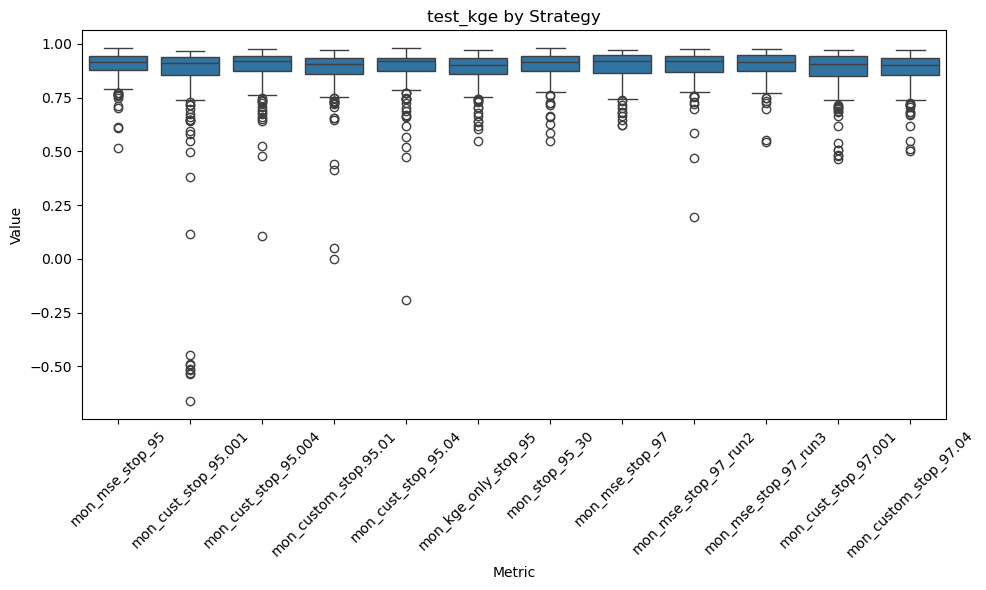

In [18]:
plot_metric_boxplots(df_summary, prefix="test_kge")

# Step 5 Compare to Results By Epoch No_stop Run 

In [19]:
run_dict_no_stop = {}
run_dict_no_stop["Mon_mse"] = "36b552505bb2495ab5d4fc44f8c87471"
run_dict_no_stop["Mon_kge"] = "47c8948e441d4101a6a045c422f9ac75"

In [20]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict_no_stop = {}
for key in run_dict_no_stop.keys(): 
    run_id = run_dict_no_stop[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict_no_stop[key] = df_metrics

In [21]:
df_dict_no_stop.keys()

dict_keys(['Mon_mse', 'Mon_kge'])

In [22]:

metric_nm = "test_kge"
epochs = 10 
df_summary_all = df_summary

for key in df_dict_no_stop.keys():
    df_metrics = df_dict_no_stop[key]
    df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
    
    for epoch in range(epochs): 
        df_epoch =  df_filtered[df_filtered["Step"] == epoch]
        # Set the index to the 'metric' column
        df_epoch = df_epoch.set_index("Metric")
        # Append the key to all other column names (except the index)
        df_epoch = df_epoch.add_suffix(f"_{key}_epoch{epoch}")
        df_epoch.columns = df_epoch.columns.str.replace("Value", metric_nm)
        df_summary_all = pd.concat([df_summary_all, df_epoch], axis=1)

df_summary_all.head()



,Step_mon_mse_stop_95,test_kge_mon_mse_stop_95,Step_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.001,Step_mon_cust_stop_95.004,test_kge_mon_cust_stop_95.004,Step_mon_custom_stop.95.01,test_kge_mon_custom_stop.95.01,Step_mon_cust_stop_95.04,test_kge_mon_cust_stop_95.04,...,Step_Mon_kge_epoch5,test_kge_Mon_kge_epoch5,Step_Mon_kge_epoch6,test_kge_Mon_kge_epoch6,Step_Mon_kge_epoch7,test_kge_Mon_kge_epoch7,Step_Mon_kge_epoch8,test_kge_Mon_kge_epoch8,Step_Mon_kge_epoch9,test_kge_Mon_kge_epoch9
Metric,,,,,,,,,,,,,,,,,,,,,
test_kge_170103020101,0,0.860028,5,0.888518,1,0.907909,1,0.940560,0,0.934592,...,5,0.942568,6,0.895966,7,0.948623,8,0.951828,9,0.940503
test_kge_170103020102,2,0.901432,0,0.930452,9,0.927475,9,0.884727,9,0.929955,...,5,0.894465,6,0.871352,7,0.890362,8,0.886356,9,0.912097
test_kge_170103020103,6,0.907718,9,0.840223,1,0.891290,3,0.905504,9,0.918831,...,5,0.925934,6,0.912363,7,0.915243,8,0.924769,9,0.900507
test_kge_170103020201,9,0.835902,9,0.880731,4,0.896078,9,0.719661,9,0.726208,...,5,0.817946,6,0.800942,7,0.802321,8,0.840444,9,0.758842
test_kge_170103020202,9,0.762706,9,0.647967,9,0.658865,9,0.704744,9,0.687009,...,5,0.798868,6,0.776222,7,0.852737,8,0.783878,9,0.787215


In [23]:
df_summary_all_slim = slim_by_prefix(df_summary_all, "test_kge")
df_summary_all_slim.describe()

,test_kge_mon_mse_stop_95,test_kge_mon_cust_stop_95.001,test_kge_mon_cust_stop_95.004,test_kge_mon_custom_stop.95.01,test_kge_mon_cust_stop_95.04,test_kge_mon_kge_only_stop_95,test_kge_mon_stop_95_30,test_kge_mon_mse_stop_97,test_kge_mon_mse_stop_97_run2,test_kge_mon_mse_stop_97_run3,...,test_kge_Mon_kge_epoch0,test_kge_Mon_kge_epoch1,test_kge_Mon_kge_epoch2,test_kge_Mon_kge_epoch3,test_kge_Mon_kge_epoch4,test_kge_Mon_kge_epoch5,test_kge_Mon_kge_epoch6,test_kge_Mon_kge_epoch7,test_kge_Mon_kge_epoch8,test_kge_Mon_kge_epoch9
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,...,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.899074,0.817899,0.889083,0.874892,0.886238,0.882529,0.896788,0.893627,0.896050,0.899657,...,0.855091,0.861733,0.867610,0.868152,0.870077,0.868040,0.866576,0.869403,0.869676,0.866537
std,0.069074,0.304456,0.099827,0.120294,0.114294,0.076678,0.070720,0.074408,0.085552,0.069116,...,0.180740,0.180458,0.154364,0.154080,0.151117,0.154293,0.152732,0.150645,0.152761,0.153446
min,0.515987,-0.661218,0.104385,0.000556,-0.191694,0.550016,0.548499,0.623924,0.196249,0.541850,...,-0.428212,-0.430480,-0.419877,-0.423825,-0.423831,-0.427220,-0.422759,-0.418292,-0.419811,-0.417105
25%,0.878463,0.856911,0.872097,0.861566,0.875771,0.859231,0.874103,0.864004,0.870596,0.873015,...,0.839574,0.850599,0.852306,0.855696,0.846625,0.847213,0.843845,0.854135,0.842516,0.846253
50%,0.916595,0.910185,0.919590,0.905118,0.920448,0.903674,0.916871,0.918607,0.919333,0.915063,...,0.889398,0.900551,0.896829,0.900356,0.900812,0.899674,0.898926,0.892664,0.901842,0.901812
75%,0.944094,0.939569,0.945504,0.936012,0.936005,0.932374,0.942238,0.946285,0.944786,0.947455,...,0.934952,0.935136,0.935854,0.930024,0.935608,0.933236,0.931284,0.931105,0.935986,0.933229
max,0.979904,0.969317,0.976972,0.970650,0.981162,0.971539,0.980497,0.973368,0.974728,0.976745,...,0.972510,0.972628,0.971812,0.972647,0.971329,0.967807,0.971826,0.973474,0.968953,0.971423


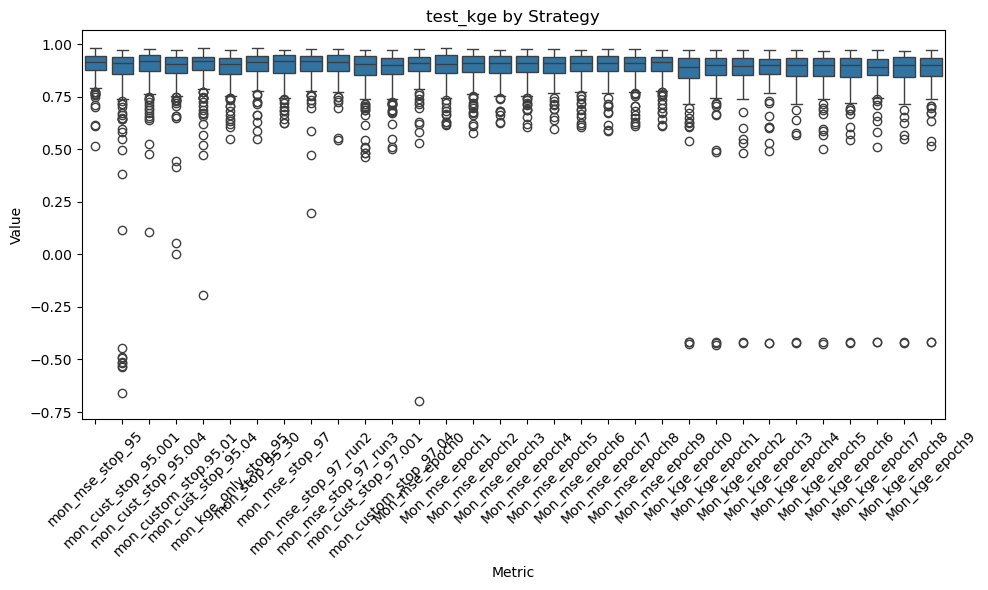

In [24]:
plot_metric_boxplots(df_summary_all, prefix="test_kge")

In [25]:
def filter_dict_by_keys(d, keys):
    return {k: d[k] for k in keys if k in d}


In [33]:
col_to_keep = ["test_kge_mon_mse_stop_97", "test_kge_mon_mse_stop_97_run2", "test_kge_mon_mse_stop_97_run3", "test_kge_mon_cust_stop_95.04", "test_kge_mon_stop_95_30", "test_kge_Mon_mse_epoch2", "test_kge_Mon_mse_epoch9"]
df_summary_small = df_summary_all[col_to_keep]
df_summary_small.describe()


,test_kge_mon_mse_stop_97,test_kge_mon_mse_stop_97_run2,test_kge_mon_mse_stop_97_run3,test_kge_mon_cust_stop_95.04,test_kge_mon_stop_95_30,test_kge_Mon_mse_epoch2,test_kge_Mon_mse_epoch9
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.893627,0.896050,0.899657,0.886238,0.896788,0.891627,0.894352
std,0.074408,0.085552,0.069116,0.114294,0.070720,0.073703,0.067824
min,0.623924,0.196249,0.541850,-0.191694,0.548499,0.575444,0.607811
25%,0.864004,0.870596,0.873015,0.875771,0.874103,0.868448,0.873603
50%,0.918607,0.919333,0.915063,0.920448,0.916871,0.910030,0.913085
75%,0.946285,0.944786,0.947455,0.936005,0.942238,0.940965,0.940260
max,0.973368,0.974728,0.976745,0.981162,0.980497,0.976274,0.973084


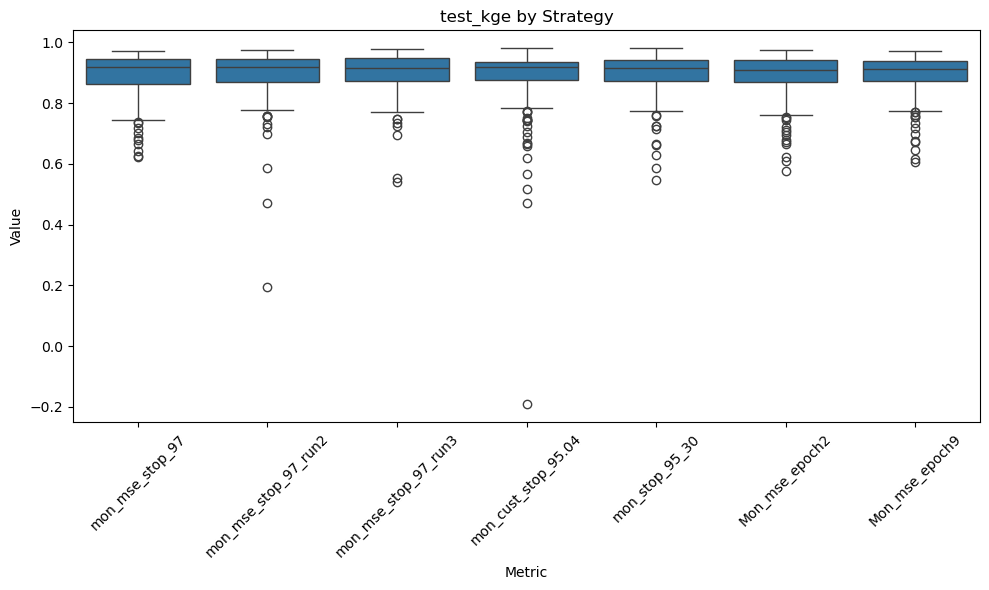

In [34]:
plot_metric_boxplots(df_summary_small, prefix="test_kge")